# Proyecto 04 - Mejora del Proyecto 3 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

Como desafío para mi proyecto final, defino las siguientes anticipaciones:

1. Definir dos modelos, cada uno por un tipo de vehículo (Pesado y Liviano), ya que como se observó en el gráfico `cantidad de pasadas de acuerdo al sentido y al tipo de vehículo por días de semana`, correspondiente al proyecto N°3, el comportamiento entre tipo de vehículos es totalmente distinto.
1. Incluir más features para definir mi modelo, tales como tipo de Vehículo, Sentido, Día de la semana, y generar así nuevamente, las predicciones para el último trimeste del año 2019, y el 2020 completo.
1. Optimizar el modelo obtenido con Prophet para predecir el año 2020, utilizando la validación cruzada, y buscando los mejores hiperparámetros.

In [1]:
# Importo las librerías necesarias
# Básicas más manejo de date
import numpy as np
import pandas as pd
import datetime

# Visualización
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns 
import plotly.graph_objs as go


# Estadísticas
from statsmodels.tsa.stattools import acf, adfuller

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
from pandas.plotting import autocorrelation_plot

# Machine learning: 
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBRegressor 

# prophet by Facebook
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import itertools

# Mediciones de Error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Preprocesamiento 
from sklearn.preprocessing import StandardScaler

# Optimización de Hiperparámetros
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


#sns.set(style="white", context="talk")
sns.set()
# Definición de Tipo, tamaño, color y ancho de las Fuentes para los títulos de los gráficos
title_font= {"family" : "Cambria",
             "size" : 18,
             "color" : "black",
             "weight" : "bold"}

#plt.rcParams.update({'figure.figsize': (10,6), 'figure.dpi': 120})

import warnings
warnings.filterwarnings("ignore")

In [2]:
def elimino_outliers(dataset,var):
    '''
    Dado un dataset y un feature 
    devuelve la mascara(filtro) 
    con los datos a eliminar en 
    ese feature del dataset aplicando
    el rango intercuantílico.
    '''
    
    q25,q75 = np.percentile(dataset[var], [25,75])
    iqr = q75 - q25
    minimo = q25 - 1.5*iqr
    maximo = q75 + 1.5*iqr
    mascara_outliers = np.logical_or(dataset[var] < minimo, dataset[var] > maximo)
    return mascara_outliers

In [3]:
def MAPE(actual, pred):
    '''
    El Error Porcentual Absoluto 
    Medio (MAPE o Mean Absolute Percentage Error)    
    '''
    
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual-pred)/actual))*100

In [4]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

Para mantener las mismas condiciones que utilicé en el proyecto 3 seguiré trabajando con la estación **Illia** y la forma de pago **Efectivo**

In [5]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['forma_pago', 'estacion'], inplace = True)

In [6]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2 y la columna periodo y hora_inicio
dataset.drop(columns=['fecha','hora_fin','periodo','hora_inicio'], inplace = True)

dataset.head(2)

dia sentido tipo_vehiculo  cantidad_pasos              fecha2
80  Martes  Centro       Liviano             537 2019-01-01 02:00:00
86  Martes  Centro        Pesado               1 2019-01-01 02:00:00

In [7]:
dataset.shape

(238869, 5)

In [8]:
# Verifico la existencia de nulos en el dataset
dataset.isnull().sum()

dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
fecha2            0
dtype: int64

In [9]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 

In [10]:
# Lo primero que debemos hacer es convertir la columna fecha, hora_fin en formata dd-mm-yyyy
dataset['fecha'] = pd.to_datetime(dataset['fecha'])
dataset

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
80        Martes     Centro       Liviano             537 2019-01-01 02:00:00
86        Martes     Centro        Pesado               1 2019-01-01 02:00:00
88        Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94        Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149       Martes     Centro       Liviano             769 2019-01-01 03:00:00
...          ...        ...           ...             ...                 ...
1372316  Domingo  Provincia        Pesado               8 2017-12-31 22:00:00
1372319  Domingo  Provincia       Liviano               8 2017-12-31 23:00:00
1372320  Domingo  Provincia       Liviano             148 2017-12-31 23:00:00
1372324  Domingo  Provincia        Pesado               1 2017-12-31 23:00:00
1372326  Domingo  Provincia        Pesado               1 2017-12-31 23:00:00

[238869 rows x 5 columns]

In [11]:
#Reordenamos el dataset por fecha. Esto es fundamental cuando trabajamos con serie de tiempo.
dataset.sort_values('fecha', inplace = True);
dataset.reset_index(drop=True, inplace = True)

In [12]:
# Cambio el indice del dataset por el campo fecha.
dataset_n = dataset.set_index('fecha')

# Este dataset es el que utilizaré para mi modelo XGboost en el que incluyo más features y para Prophet mejorado
data = dataset_n
data

dia    sentido tipo_vehiculo  cantidad_pasos
fecha                                                                
2017-01-01 00:00:00  Domingo  Provincia        Pesado               1
2017-01-01 00:00:00  Domingo  Provincia       Liviano               9
2017-01-01 00:00:00  Domingo  Provincia       Liviano             644
2017-01-01 00:00:00  Domingo  Provincia        Pesado               6
2017-01-01 00:00:00  Domingo  Provincia        Pesado               1
...                      ...        ...           ...             ...
2019-12-31 22:00:00   Martes  Provincia       Liviano             556
2019-12-31 22:00:00   Martes  Provincia        Pesado               1
2019-12-31 22:00:00   Martes     Centro       Liviano             580
2019-12-31 23:00:00   Martes     Centro       Liviano             214
2019-12-31 23:00:00   Martes  Provincia       Liviano             190

[238869 rows x 4 columns]

#  1.

* Definir dos modelos cada uno con un tipo de vehículo (Pesado y Liviano) ya que como se observa en el gráfico `cantidad de pasadas de acuerdo al sentido y al tipo de vehículo por días de semana`  el comportamiento entre tipo de vehículos es totalmente distinto.
---
---

In [13]:
# Separación de los datos de acuerdo al tipo de vehículo.
liviano = dataset_n[dataset_n.tipo_vehiculo == 'Liviano']
pesado = dataset_n[dataset_n.tipo_vehiculo == 'Pesado']

In [14]:
print('Liviano: ', str(liviano.shape))
print('Pesado: ', str(pesado.shape))

Liviano:  (87348, 4)
Pesado:  (151521, 4)


---  
## MODELO VEHICULOS LIVIANOS
---  
### 1- Análisis de Exploratorio de los Datos Vehículos Livianos

In [15]:
liviano.shape

(87348, 4)

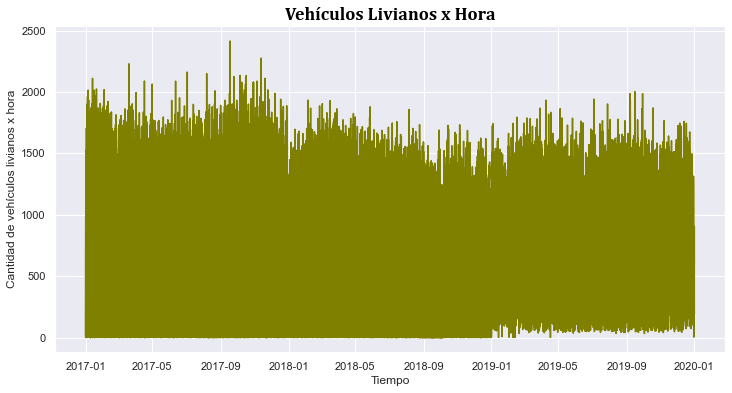

In [16]:
# Visulizo la serie de vehículos livianos
plt.figure(figsize = (12,6))
plt.plot(liviano.index, liviano.cantidad_pasos,color='olive')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos livianos x hora')
plt.title('Vehículos Livianos x Hora', fontdict=title_font)
plt.show();

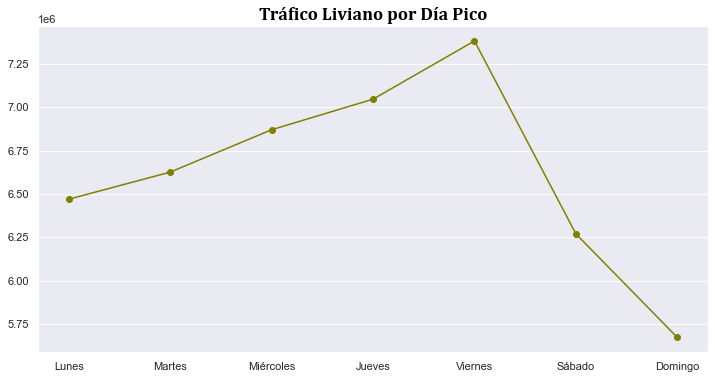

In [17]:
plt.figure(figsize = (12,6))
by_weekday = liviano.groupby(liviano.index.dayofweek).sum()
by_weekday.index = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
plt.plot(by_weekday, color='olive', marker='o')
plt.title('Tráfico Liviano por Día Pico', fontdict=title_font)
plt.grid(axis='x')
plt.show();

* Con respecto al **tráfico liviano diario** se puede observar que los días de la semana con `mayor tráfico liviano` son los `Viernes` mientras que los días de `menor tráfico liviano` son los días `Domingo`.

<Figure size 864x432 with 0 Axes>

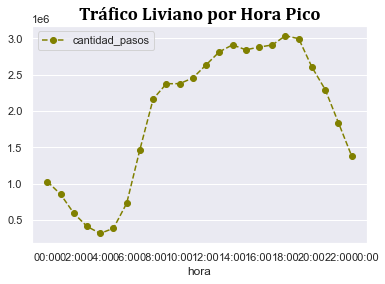

In [18]:
plt.figure(figsize = (12,6))
by_time = liviano.groupby(liviano.index.time).sum()
hourly_ticks = 2 * 60 * 60 *  np.arange(13)
by_time.plot(xticks=hourly_ticks, style='--o', color='olive')
plt.title('Tráfico Liviano por Hora Pico', fontdict=title_font)
plt.xlabel('hora')
plt.grid(axis='x')
plt.show();

* En el  gráfico superior se observa el **tráfico liviano por hora pico** que esta dado entre la franja horaria de las `8hs y 19hs`. Comienza a crecer a las 6 de la mañana, se mantiene oscilante durante el día y empieza a decrecer a partir de las 18hs. Esto efectivamente concuerda con el inicio y fin de la jornada laboral.

###  a) Análisis de Valores Atípicos o Outliers de los Vehículos Livianos


* Para lograr una mejor visualización de los datos aplicaré al dataset un resampleo diario ya que no sólo me permitirá tener una mejor comprensión de  mis datos sino también la posibilidad de resumir información en una granularidad de tiempo más grande, en este caso `Día`. Y como estoy trabajando con cantidad de pasadas de autos aplicaré como función de agregación la suma y así logro unificar mis datos día a día. 

In [19]:
#Resampleamos nuestros datos para agrupar por DIA 
diario_liv = liviano.resample('D').sum()
print(diario_liv.shape)
diario_liv.head(3)

(1095, 1)


cantidad_pasos
fecha                     
2017-01-01           30641
2017-01-02           48979
2017-01-03           48322

In [20]:
#Para ello utilizaré la función elimino_outliers que implementa los rangos interquantilicos 
dataset_outliers = elimino_outliers(diario_liv,'cantidad_pasos')
dataset_outliers.sum()

16

In [21]:
# Reemplazo los outliers por nan  y aplico la interpolacion a la serie
diario_liv[dataset_outliers] = np.nan
print(diario_liv.isnull().sum())
diario_liv = diario_liv.interpolate(method='time')
print(diario_liv.isnull().sum())

cantidad_pasos    16
dtype: int64
cantidad_pasos    0
dtype: int64


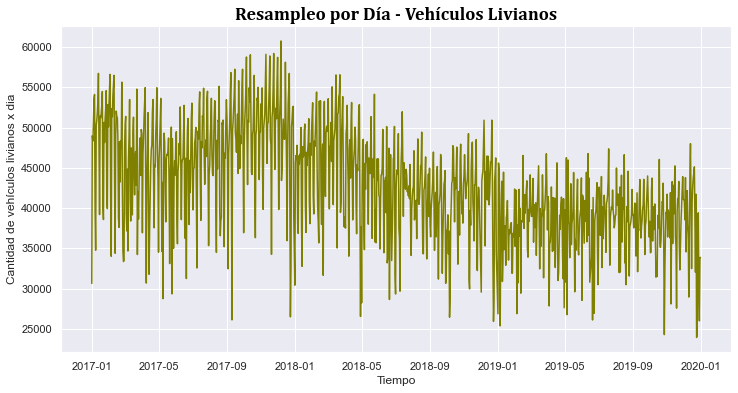

In [22]:
# Visulizo nuevamente los datos pero sin los outliers
plt.figure(figsize = (12,6))
plt.plot(diario_liv.index, diario_liv.cantidad_pasos,color='olive')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos livianos x dia')
plt.title('Resampleo por Día - Vehículos Livianos', fontdict=title_font)
plt.show();

* Nuevamente se observa como año a año el flujo vehícular va decreciendo y a nivel del movimiento mensual durante el año se observa que los meses también presentan fluctuaciones encontrando meses con menor flujo vehícular que otros.

In [23]:
diario_liv.head(3)

cantidad_pasos
fecha                     
2017-01-01         30641.0
2017-01-02         48979.0
2017-01-03         48322.0

### 2- Predicción a Futuro: Modelo Vehículos Livianos 
---

### a) Predicción último trimestre del 2019 - Vehículos Livianos

### One-Step Prediction

* Debido a que en el proyecto 3 obtuve mejor predicción aplicando como método para la separación de los datos en train y en test One-Step Prediction aplicaré solo esta opción en mis predicciones para el Modelo de vehículos Livianos.

* Nuevamente defino una ventana(lag) con la cual entrenaré mi modelo de 365 días ya que considero que con esa información el modelo podra aprender mejor y así arrojará predicciones más certeras.


In [24]:
senial_liv = diario_liv.cantidad_pasos

In [25]:
senial_liv.head()

fecha
2017-01-01    30641.0
2017-01-02    48979.0
2017-01-03    48322.0
2017-01-04    50581.0
2017-01-05    53622.0
Freq: D, Name: cantidad_pasos, dtype: float64

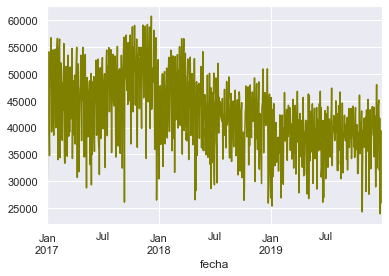

In [26]:
senial_liv.plot(color='olive');

In [27]:
# Ventana con la cual entrenaré mi modelo, es decir cuántos valores hacia atrás tomo para predecir el valor siguiente.
look_back = 365

In [28]:
#Creamos los X e y con ceros para luego llenar con los datos. 
N = senial_liv.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(729, 365) (729,)


In [29]:
#Llenamos los X y los y
for i in range(X.shape[0]):
    X[i,:] = senial_liv.iloc[i:i+look_back]
    y[i] = senial_liv.iloc[i+look_back]

In [30]:
# Definimos nuestros datos de Train y Test 
N_train = (365*2) + (364-92) - look_back # cantidad de instancias que vamos a usar para entrenar.Son 2 años y 9 meses( 637 días)
N_test = 92  #cantidad de puntos que vamos a usar para evaluar (3 meses -- 92 días)
N_total = N_train + N_test
print(N_train)
print(N_test)
length_total = N_train + N_test + look_back

print (length_total)

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

637
92
1094
(637, 365) (637,)
(92, 365) (92,)


In [31]:
# Defino el modelo con los valores por defecto, es decir, sin la definición de ningún hiperparametro.
xr_liv = xgb.XGBRegressor()

In [32]:
# Entreno el modelo
xr_liv.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
# Predigo 
y_pred = xr_liv.predict(X)
y_train_pred = xr_liv.predict(X_train)
y_test_pred = xr_liv.predict(X_test)

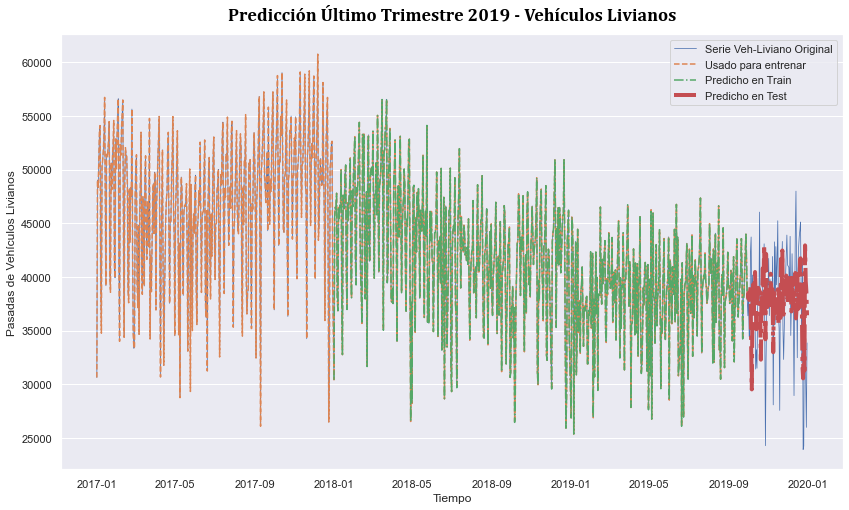

In [34]:
# Gráfico comparativo entre la Serie Original, el Train y lo predicho en Train y Test.
plt.figure(figsize=(14,8))
plt.plot(senial_liv.index[:length_total], senial_liv[:length_total],lw = 0.75, label = 'Serie Veh-Liviano Original')
plt.plot(senial_liv.index[:N_train + look_back], senial_liv[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial_liv.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial_liv.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.title('Predicción Último Trimestre 2019 - Vehículos Livianos', fontdict=title_font, pad= 15)
plt.xlabel('Tiempo')
plt.ylabel('Pasadas de Vehículos Livianos')
plt.grid(axis='x')
plt.show();

In [35]:
# Analizo el error de mediante el calculo el RMSE  y el MAPE en train y test
print('ERROR en modelo Vehículos LIVIANOS')
MSE = mean_squared_error(y_train, y_train_pred)
print('  RMSE en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('  RMSE en Test:',np.sqrt(MSE))

# Calculo el MAPE en train y test
print('  MAPE en Train: ',MAPE(y_train, y_train_pred))
print('  MAPE en Test:', MAPE(y_test, y_test_pred))

ERROR en modelo Vehículos LIVIANOS
  RMSE en Train: 6.398272984821922
  RMSE en Test: 4778.463362874385
  MAPE en Train:  0.01217657985688815
  MAPE en Test: 10.465354177066704


*  Visulamente la predicción no parece tan mala. Analizando el error del modelo observo que el  `MAPE` en test es igual a 10.46 en promedio lo que significa que `mi pronóstico está errado en un 10%`. Con respecto al `RMSE` tengo un diferencia que oscila entre `+/- 4778 vehículos livianos` por pasadas. 

### b) Benchmark Vehículos Livianos

* Defino mi modelo de Benchmark como la comparación del error con el que habría obtenido si predecía copiando el valor de la fecha anterior.

In [36]:
#Defino mi predicción
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

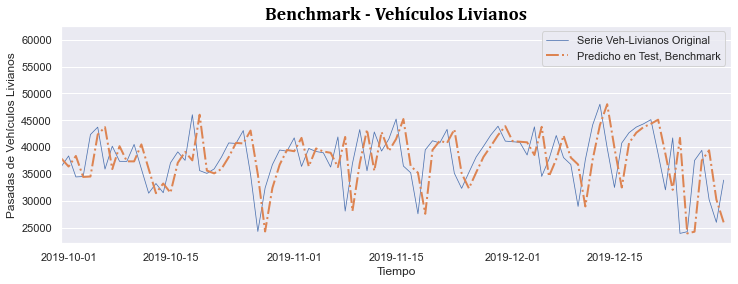

In [37]:
# Grafico comparativo entre la Serie Original y la Predicha en Test
plt.figure(figsize=(12,4))
plt.plot(senial_liv.index[:length_total], senial_liv[:length_total],lw = 0.75, label = 'Serie Veh-Livianos Original')
plt.plot(senial_liv.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, 
         label = 'Predicho en Test, Benchmark')
plt.xlim(senial_liv.index[N_train+look_back], senial_liv.index[length_total])
plt.xlabel('Tiempo')
plt.ylabel('Pasadas de Vehículos Livianos')
plt.title('Benchmark - Vehículos Livianos', fontdict=title_font)
plt.legend()
plt.grid(axis='x')
plt.show();

In [38]:
# Predigo
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

In [39]:
# Calculo el RMSE y el MAPE en test
print('ERROR Benchmark Vehículos LIVIANOS')
MSE = mean_squared_error(y_test, y[-1 + N_train:N_train+N_test - 1])
print('  RMSE en Test:',np.sqrt(MSE))

print('  MAPE en Test:', MAPE(y_test, y[-1 + N_train:N_train+N_test - 1]))

ERROR Benchmark Vehículos LIVIANOS
  RMSE en Test: 5774.832007720338
  MAPE en Test: 12.720968440170397


* Visualmente se observa la el dibujo de la serie desfazado en un día (tal cual definí mi modelo de BenchmarK). En cuanto al análisis de los errores en este caso,  el `MAPE` es igual a 13.06 en promedio lo que significa que `mi pronóstico está errado en un 12%`. Con respecto al `RMSE` tengo un diferencia que oscila entre `+/- 5774 vehículos` por pasadas. Esto significa que me primer modelo obtuvo una mejor predicción que mi benchmark.

### c)  Optimización de Hiperparámetros de mi modelo XGboost para Vehículos Livianos

* Mi siguiente paso será optimizar mi modelo de XGBoost para Vehículos Livianos ya que la predicción la realize con los valores por defecto. Para ello utilizaré el `randomsearchCV` para obtener los mejores hiperparémetros y ver si entrenando nuevamente el modelo con los hiperparametros obtenidos obtengo una mejor predicción.

In [40]:
# base parameters
params = {
    'max_depth': range (2, 20, 2),
    'min_child_weight': [4],
    'n_estimators': range(60, 220, 400),
    'colsample_bytree': [0.1,0.3,0.5,0.7,1],
    'learning_rate': [0.1, 0.01, 0.05]
}

search_xparli = RandomizedSearchCV(xr_liv, params, n_jobs=10, cv=10,
                                 verbose=True, scoring='neg_mean_squared_error')

search_xparli.fit(X_train, y_train)

print('Mejores Hiperparámetros: '+str(search_xparli.best_params_))
print('Mejor Score:'+str(search_xparli.best_score_)+'\n')

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   54.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  1.5min finished


Mejores Hiperparámetros: {'n_estimators': 60, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.3}
Mejor Score:-18785280.276667614



In [41]:
# Defino el modelo con los mejores Hiperpáremtros obtenidos 

xrb_liv = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=180, max_depth=8, learning_rate= 0.05,
                        min_child_weight=4,colsample_bytree=0.3, random_state=42)

# Entreno  el modelo 
xrb_liv.fit(X_train,y_train)

# Predigo 
y_pred = xrb_liv.predict(X)
y_train_pred = xrb_liv.predict(X_train)
y_test_pred = xrb_liv.predict(X_test)

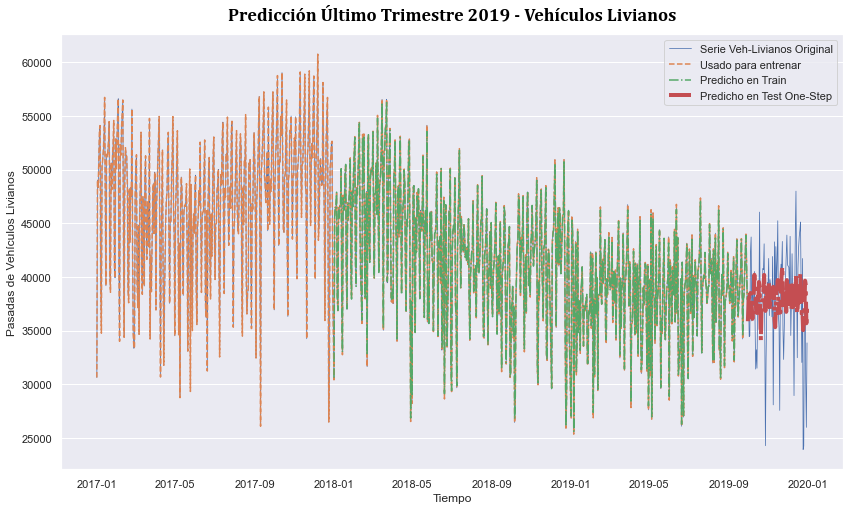

In [42]:
# Grafico comparativo entre la Serie Original, el Train y lo predicho en Train y Test con el One-Step
plt.figure(figsize=(14,8))
plt.plot(senial_liv.index[:length_total], senial_liv[:length_total],lw = 0.75, label = 'Serie Veh-Livianos Original')
plt.plot(senial_liv.index[:N_train + look_back], senial_liv[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial_liv.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial_liv.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test One-Step')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Pasadas de Vehículos Livianos')
plt.title('Predicción Último Trimestre 2019 - Vehículos Livianos', fontdict=title_font, pad=15)
plt.grid(axis='x')
plt.show();

In [43]:
# Calculo el RMSE  y el MAPE en train y test
print('ERROR en modelo Vehículos LIVIANOS')
MSE = mean_squared_error(y_train, y_train_pred)
print('  RMSE en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('  RMSE en Test:',np.sqrt(MSE))

# Calculo el MAPE en train y test
print('  MAPE en Train: ',MAPE(y_train, y_train_pred))
print('  MAPE en Test:', MAPE(y_test, y_test_pred))

ERROR en modelo Vehículos LIVIANOS
  RMSE en Train: 168.160760417087
  RMSE en Test: 4455.0101385413245
  MAPE en Train:  0.31433684045950483
  MAPE en Test: 9.908480214367819


* Mi `modelo XGboost para Vehículos Livianos` optimizados arroja un `MAPE` en test que es igual a 9.9 en promedio lo que significa que `mi pronóstico está errado en un 10%` no cambia mucho con respecto al modelo sin optimizar. Con respecto al `RMSE` tengo un diferencia que oscila entre `+/- 4455 vehículos` por pasadas esto si mejora logrando reducir en     el margen de error por más o por menos.

### d) Predicción año 2020 - Vehículos Livianos

* Para realizar dicha predicción necesito generar todas las fechas de dicho año para poder con el modelo elegido realizar la prediccion del mismo. Para ello a partir del último valor de mi serie genero mediante la utilización de la función de pandas `datatime.timedelta` la siguientes fechas.

In [44]:
senial_liv.shape

(1095,)

In [45]:
# Me paro en el último día de mi serie diario
liviano.index[-1]

Timestamp('2019-12-31 23:00:00')

In [46]:
# Con esta función de panda le sumo un día.
liviano.index[-1]+datetime.timedelta(days=1)

Timestamp('2020-01-01 23:00:00')

In [47]:
# A través de un for voy a generar todo el 2020.
days_2020=[]
primerdia = liviano.index[-1]+datetime.timedelta(days=1)
for i in range(0,366):
    nextday = primerdia + datetime.timedelta(days=i)
    days_2020.append(nextday)    

In [48]:
# Transformo mi lista en una serie creando la fecha como índice
serie_liv = pd.Series(index=days_2020)

In [49]:
# Por último uno el año 2020 generado a mi serie (senial)
lsenial = pd.concat([senial_liv, serie_liv])
lsenial.shape

(1461,)

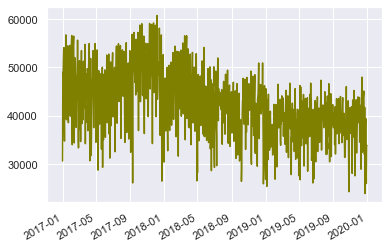

In [50]:
# Dibujo mi nuevo dataset
lsenial.plot(color='olive');

In [51]:
# Creo los X e y con ceros para luego llenar con los datos con mi nuevo dataset.
N = lsenial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(1095, 365) (1095,)


In [52]:
#Llenamos los X y los y
for i in range(X.shape[0]):
    X[i,:] = lsenial.iloc[i:i+look_back]
    y[i] = lsenial.iloc[i+look_back]

In [53]:
# Definimos nuestros datos de Train y Test (Manteniendo mi look_back de 365 días)
N_train = (365*2) + (364) - look_back # cantidad de instancias que vamos a usar para entrenar. (2 años)
N_test = 366  #cantidad de puntos que vamos a usar para evaluar (1 año)
N_total = N_train + N_test
print(N_total)
length_total = N_train + N_test + look_back

print (length_total)

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

1095
1460
(729, 365) (729,)
(366, 365) (366,)


In [54]:
# Genero mi predicción (forecast) para el año 2020 de Vehículos Liviano
y_ms_test_pred = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred = xrb_liv.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

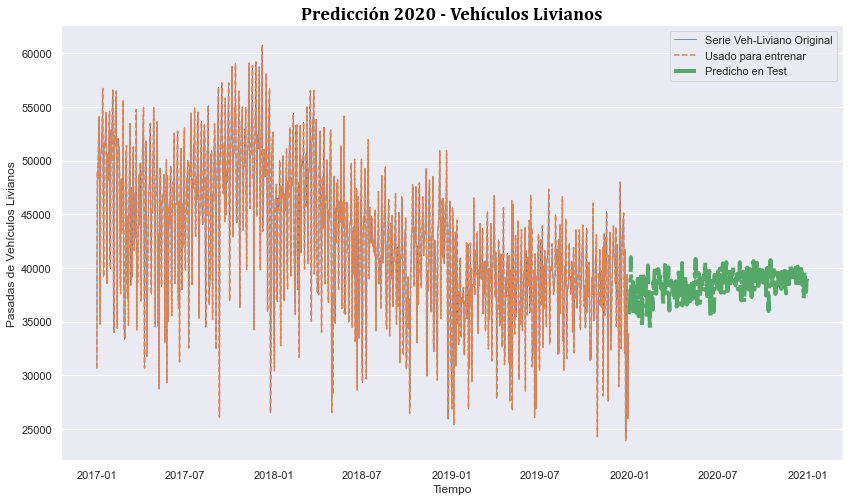

In [55]:
# Grafico comparativo entre la Serie Original, el Train y lo predicho en Train y Test.
plt.figure(figsize=(14,8))
plt.plot(lsenial.index[:length_total], lsenial[:length_total],lw = 0.75, label = 'Serie Veh-Liviano Original')
plt.plot(lsenial.index[:N_train + look_back], lsenial[:N_train + look_back],'--', label = 'Usado para entrenar')
#plt.plot(nsenial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(lsenial.index[N_train+look_back: length_total], y_ms_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Pasadas de Vehículos Livianos')
plt.title('Predicción 2020 - Vehículos Livianos', fontdict=title_font)
plt.grid(axis='x')
plt.show();

* Se puede observar que la predicción que obtengo con mi modelo de XGBoost para Vehículos Livianos para el año 2020 no fue tan mala. Dicha predicción se obtiene con la información de un año para atrás por el cual su comportamiento resulta bastante parecido al año 2019. Teniendo mayor información (ventana hacia atrás) para predecir, en general, la predicción sería algo mejor pero para este caso en particular,  analizando la tendencia decreciente y el comportamiento de la serie considro que más información no mejoraría mucho la predicción que obtuve para el 2020.

---  
## MODELO VEHICULOS PESADOS
---  
### 1- Análisis de Exploratorio de los Datos Vehículos Pesados

In [56]:
pesado.shape

(151521, 4)

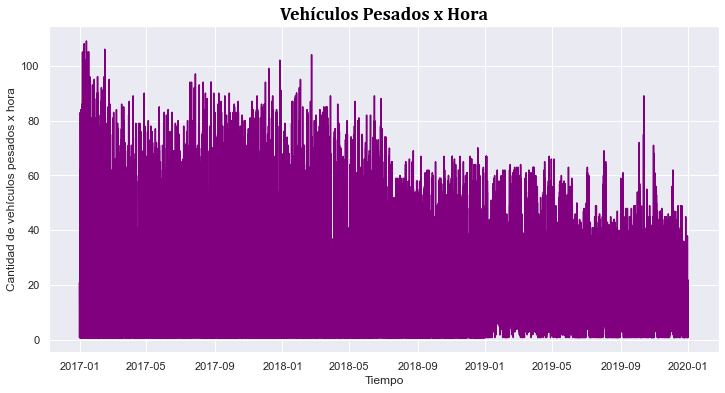

In [57]:
# Visulizo la serie de vehículos pesados 
plt.figure(figsize = (12,6))
plt.plot(pesado.index, pesado.cantidad_pasos,color='purple')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos pesados x hora')
plt.title('Vehículos Pesados x Hora', fontdict=title_font)
plt.show();

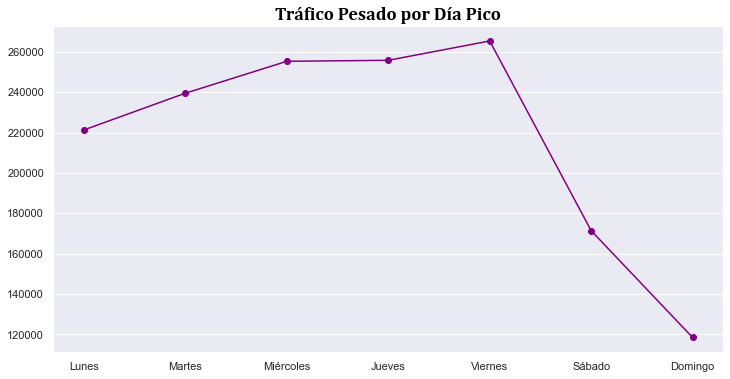

In [58]:
plt.figure(figsize = (12,6))
by_weekday = pesado.groupby(pesado.index.dayofweek).sum()
by_weekday.index = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
plt.plot(by_weekday, color='purple', marker='o')
plt.title('Tráfico Pesado por Día Pico', fontdict=title_font)
plt.grid(axis='x')
plt.show();

Con respecto al `tráfico pesado diario` se observa un comportamiento parecido al `tráfico liviano diario` siendo los `Viernes el día con mayor tráfico` y los días `Domingo el de menor tráfico`. La diferencia se observa primero en el número de pasadas donde Tráfico Pesado es significativamente menor además se observa que su comportamiento durante la semana presenta un leve diferencia ya que a partir del miércoles se mantiene hasta llegar al pico el viernes y luego presentan la misma caída hasta el domingo.

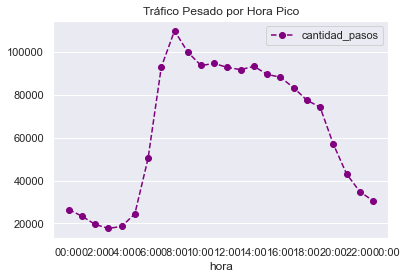

In [59]:
by_time = pesado.groupby(pesado.index.time).sum()
hourly_ticks = 2 * 60 * 60 *  np.arange(13)
by_time.plot(xticks=hourly_ticks, style='--o', color='purple')
plt.title('Tráfico Pesado por Hora Pico')
plt.xlabel('hora')
plt.grid(axis='x')
plt.show();

* Se observa en este gráfico de `tráfico pesado por hora pico` que la hora `8hs` marca el pico más alto y a partir de ahí  decrecé bruscamente para luego seguir decreciendo pero teniendo algunos períodos más constantes para luego empezar a caer a partir de 17 hs.

### a) Análisis de Valores Atípicos o Outliers de los Vehículos Pesados

In [60]:
#Resampleamos nuestros datos para agrupar por DIA 
diario_pes = pesado.resample('D').sum()
print(diario_pes.shape)
diario_pes.head(3)

(1095, 1)


cantidad_pasos
fecha                     
2017-01-01             542
2017-01-02            2589
2017-01-03            2771

In [61]:
#Para ello utilizaré la función elimino_outliers que implementa los rangos interquantilicos 
dataset_outliers = elimino_outliers(diario_pes,'cantidad_pasos')
dataset_outliers.sum()

0

In [62]:
# Reemplazo los outliers por nan  y aplico la interpolacion a la serie
diario_pes[dataset_outliers] = np.nan
print(diario_pes.isnull().sum())
diario_pes = diario_pes.interpolate(method='time')
print(diario_pes.isnull().sum())

cantidad_pasos    0
dtype: int64
cantidad_pasos    0
dtype: int64


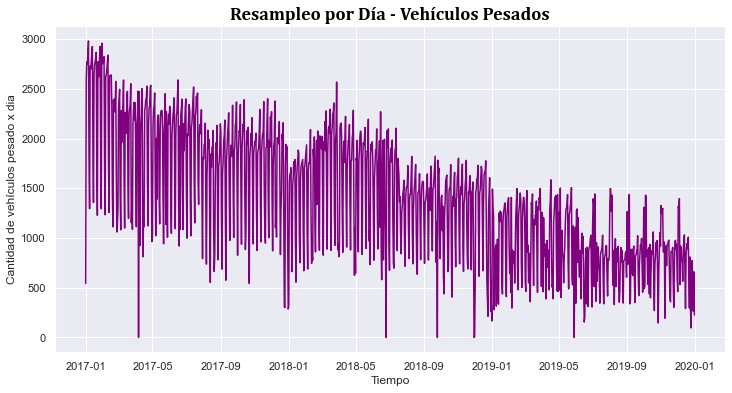

In [63]:
# Visulizo nuevamente los datos pero sin los outliers
plt.figure(figsize = (12,6))
plt.plot(diario_pes.index, diario_pes.cantidad_pasos,color='purple')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos pesado x dia')
plt.title('Resampleo por Día - Vehículos Pesados', fontdict=title_font)
plt.show();

* `No se observan outliers para la serie de datos de Vehículos Pesados`. Además se puede observar que por ejemplo para el 1 de enero del 2017 la cantidad de pasadas de vehículos pesados fue de 542 mientras que para el mismo día la cantidad de pasadas de vehículos livianos fue de 30641. Con esta comparación es notable la diferencia que existe del volumnes del tráfico de los distintos tipos de vehículos.

### 2- Predicción a Futuro: Modelo Vehículos Pesados
---

### a) Predicción último trimestre del 2019 - Vehículos Pesados

### One-Step Prediction

In [64]:
senial_pes= diario_pes.cantidad_pasos

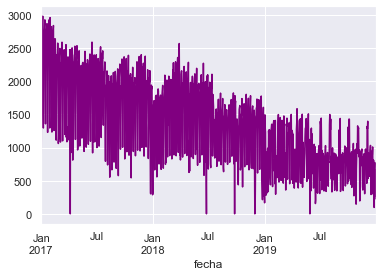

In [65]:
senial_pes.plot(color='purple');

* Se puede observar que el comportamiento de la serie de Vehículos Pesados es distinta a la de los Livianos. En el caso de los `vehículos Pesados`, el  movimiento decreciente, con pequeños picos de crecimiento, presenta en general una `marcada tendencia decreciente año a año`, mientras que, en la serie de `vehículos Livianos`, se visualizan también picos de crecimiento, pero la `tendencia decreciente es mucho más suave`.

In [66]:
#Creamos los X e y con ceros para luego llenar con los datos.
N = senial_pes.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(729, 365) (729,)


In [67]:
#Llenamos los X y los y
for i in range(X.shape[0]):
    X[i,:] = senial_pes.iloc[i:i+look_back]
    y[i] = senial_pes.iloc[i+look_back]

In [68]:
# Definimos nuestros datos de Train y Test 
# cantidad de instancias que vamos a usar para entrenar.Son 2 años y 9 meses( 637 días)
N_train = (365*2) + (364-92) - look_back 
N_test = 92  #cantidad de puntos que vamos a usar para evaluar (3 meses -- 92 días)
N_total = N_train + N_test
print(N_train)
print(N_test)
length_total = N_train + N_test + look_back

print (length_total)

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

637
92
1094
(637, 365) (637,)
(92, 365) (92,)


In [69]:
# Defino el modelo de Vehículos Pesados con los valores por defecto, es decir, sin la definición de ningún hiperparametro.
xr_pes = xgb.XGBRegressor()

In [70]:
# Entreno el modelo
xr_pes.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [71]:
# Predigo 
y_pred = xr_pes.predict(X)
y_train_pred = xr_pes.predict(X_train)
y_test_pred = xr_pes.predict(X_test)

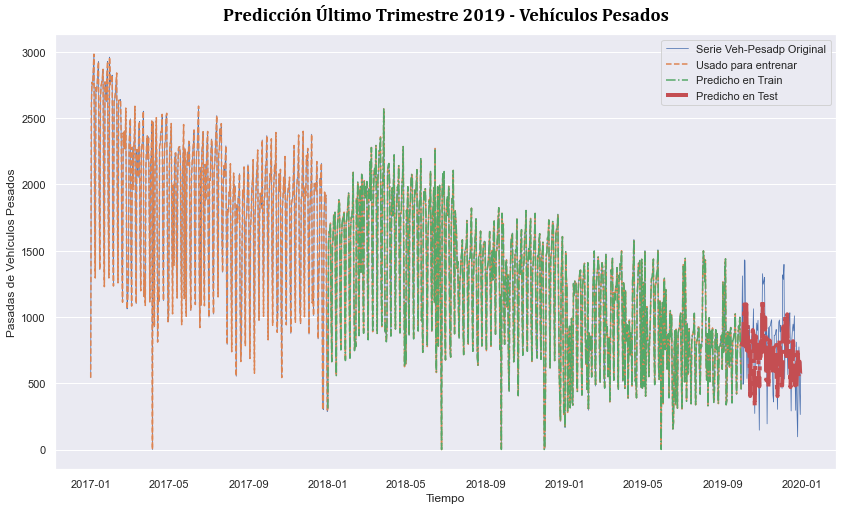

In [72]:
# Gráfico comparativo entre la Serie Original, el Train y lo predicho en Train y Test.
plt.figure(figsize=(14,8))
plt.plot(senial_pes.index[:length_total], senial_pes[:length_total],lw = 0.75, label = 'Serie Veh-Pesadp Original')
plt.plot(senial_pes.index[:N_train + look_back], senial_pes[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial_pes.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial_pes.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.title('Predicción Último Trimestre 2019 - Vehículos Pesados', fontdict=title_font, pad= 15)
plt.xlabel('Tiempo')
plt.ylabel('Pasadas de Vehículos Pesados')
plt.grid(axis='x')
plt.show();

In [73]:
# Analizo el error de mediante el calculo el RMSE  y el MAPE en train y test
print('ERROR en modelo Vehículos PESADOS')
MSE = mean_squared_error(y_train, y_train_pred)
print('  RMSE en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('  RMSE en Test:',np.sqrt(MSE))

# Calculo el MAPE en train y test
print('  MAPE en Train: ',MAPE(y_train, y_train_pred))
print('  MAPE en Test:', MAPE(y_test, y_test_pred))

ERROR en modelo Vehículos PESADOS
  RMSE en Train: 0.4977193324689729
  RMSE en Test: 275.55989218981364
  MAPE en Train:  inf
  MAPE en Test: 41.832492660953484


*  Visulamente la predicción fue mala. Analizando el error del modelo observo que el  `MAPE` en test es igual a 41.83 en promedio lo que significa que `mi pronóstico está errado en un 41%`. Con respecto al `RMSE` tengo un diferencia que oscila entre `+/- 275 vehículos pesado` por pasadas. 

### b) Benchmark Vehículos Pesados

* Defino mi modelo de Benchmark como la comparación del error con el que habría obtenido si predecía copiando el valor de la fecha anterior.

In [74]:
#Defino mi predicción
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

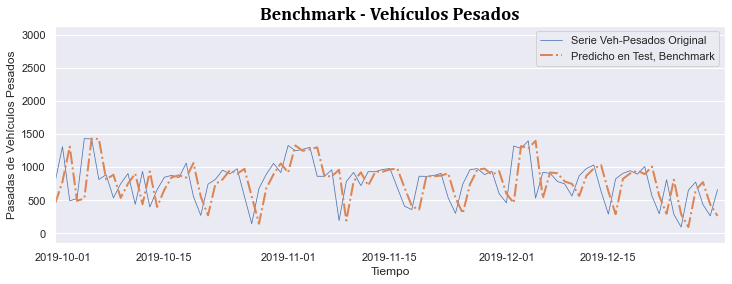

In [75]:
# Grafico comparativo entre la Serie Original y la Predicha en Test
plt.figure(figsize=(12,4))
plt.plot(senial_pes.index[:length_total], senial_pes[:length_total],lw = 0.75, label = 'Serie Veh-Pesados Original')
plt.plot(senial_pes.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, 
         label = 'Predicho en Test, Benchmark')
plt.xlim(senial_pes.index[N_train+look_back], senial_pes.index[length_total])
plt.xlabel('Tiempo')
plt.ylabel('Pasadas de Vehículos Pesados')
plt.title('Benchmark - Vehículos Pesados', fontdict=title_font)
plt.legend()
plt.grid(axis='x')
plt.show();

In [76]:
# Predigo
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

In [77]:
# Calculo el RMSE y el MAPE en test
print('ERROR Benchmark Vehículos PESADOS')
MSE = mean_squared_error(y_test, y[-1 + N_train:N_train+N_test - 1])
print('  RMSE en Test:',np.sqrt(MSE))

print('  MAPE en Test:', MAPE(y_test, y[-1 + N_train:N_train+N_test - 1]))

ERROR Benchmark Vehículos PESADOS
  RMSE en Test: 344.7010204195237
  MAPE en Test: 48.07773550756176


* En cuanto al análisis de los errores para el Benchmark tenemos el `MAPE` es igual a 48.07 en promedio lo que significa que `mi pronóstico está errado en un 48%`. Con respecto al `RMSE` tengo un diferencia que oscila entre `+/- 344 vehículos` por pasadas. Esto significa que me primer modelo obtuvo una mejor predicción que mi benchmark.

### c)  Optimización de Hiperparámetros de mi modelo XGboost para Vehículos Pesados

* Mi suguiente paso será optimizar mi modelo de XGBoost para Vehículos Pesados ya que la predicción la realize con los valores por defecto. Para ello utilizaré el `randomsearchCV` para obtener los mejores hiperparémetros y ver si entrenando nuevamente el modelo con los hiperparametros obtenidos obtengo una mejor predicción.

In [78]:
# base parameters
params = {
    'max_depth': range (2, 20, 2),
    'min_child_weight': [4],
    'n_estimators': range(60, 220, 400),
    'colsample_bytree': [0.1,0.3,0.5,0.7,1],
    'learning_rate': [0.1, 0.01, 0.05]
}

search_xparpe = RandomizedSearchCV(xr_pes, params, n_jobs=10, cv=10,
                                 verbose=True, scoring='neg_mean_squared_error')

search_xparpe.fit(X_train, y_train)

print('Mejores Hiperparámetros: '+str(search_xparpe.best_params_))
print('Mejor Score:'+str(search_xparpe.best_score_)+'\n')

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   27.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  1.2min finished


Mejores Hiperparámetros: {'n_estimators': 60, 'min_child_weight': 4, 'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Mejor Score:-98393.66306878168



In [79]:
# Defino el modelo con los mejores Hiperpáremtros obtenidos 

xrb_pes = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=180, max_depth=6, learning_rate= 0.05,
                        min_child_weight=4,colsample_bytree=0.1, random_state=42)

# Entreno  el modelo 
xrb_pes.fit(X_train,y_train)

# Predigo 
y_pred = xrb_pes.predict(X)
y_train_pred = xrb_pes.predict(X_train)
y_test_pred = xrb_pes.predict(X_test)

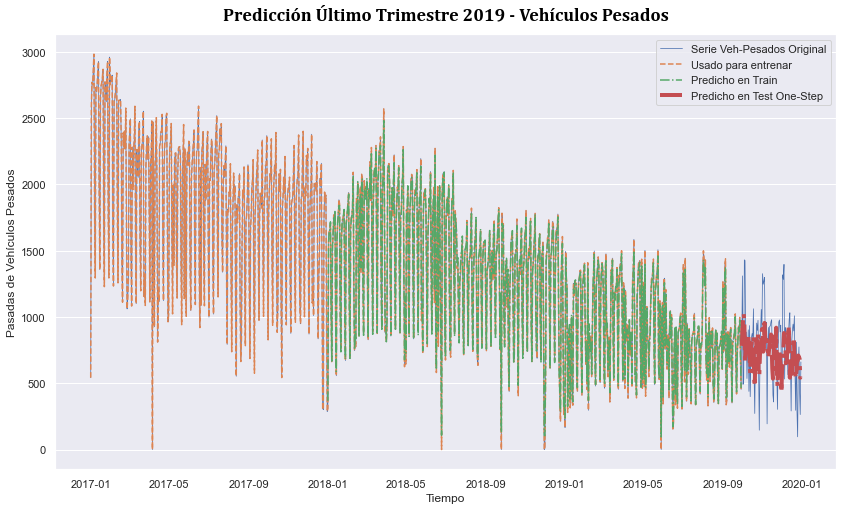

In [80]:
# Grafico comparativo entre la Serie Original, el Train y lo predicho en Train y Test con el One-Step
plt.figure(figsize=(14,8))
plt.plot(senial_pes.index[:length_total], senial_pes[:length_total],lw = 0.75, label = 'Serie Veh-Pesados Original')
plt.plot(senial_pes.index[:N_train + look_back], senial_pes[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial_pes.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial_pes.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test One-Step')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Pasadas de Vehículos Pesados')
plt.title('Predicción Último Trimestre 2019 - Vehículos Pesados', fontdict=title_font, pad=15)
plt.grid(axis='x')
plt.show();

In [81]:
# Calculo el RMSE  y el MAPE en train y test
print('ERROR en modelo Vehículos PESADOS')
MSE = mean_squared_error(y_train, y_train_pred)
print('  RMSE en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('  RMSE en Test:',np.sqrt(MSE))

# Calculo el MAPE en train y test
print('  MAPE en Train: ',MAPE(y_train, y_train_pred))
print('  MAPE en Test:', MAPE(y_test, y_test_pred))

ERROR en modelo Vehículos PESADOS
  RMSE en Train: 33.21159887555943
  RMSE en Test: 267.64587714285733
  MAPE en Train:  inf
  MAPE en Test: 39.15116152685203


* Mi `modelo XGboost para Vehículos Pesados` con los hiperparametros optimizados arroja un `MAPE` en test que es igual a 39.15 en promedio lo que significa que `mi pronóstico está errado casi en un 40%` se logró una leve mejora con respecto al modelo sin optimizar. Con respecto al `RMSE` tengo un diferencia que oscila entre `+/- 267 vehículos` por pasadas-

### d) Predicción año 2020 - Vehículos Pesados

* Para realizar dicha predicción necesito generar todas las fechas de dicho año para poder con el modelo elegido realizar la prediccion del mismo. Para ello utilizaré la lista days_2020 que había generado para el modelo de vehículos livianos a diferencia que ahora se la anexaré a la serie de vehículos pesados.

In [82]:
# Por último uno el año 2020 generado a mi serie (senial)
psenial = pd.concat([senial_pes, serie_liv])
psenial.shape

(1461,)

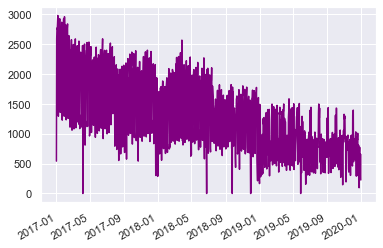

In [83]:
# Dibujo mi nuevo dataset
psenial.plot(color='purple');

In [84]:
# Creo los X e y con ceros para luego llenar con los datos con mi nuevo dataset.
N = psenial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(1095, 365) (1095,)


In [85]:
#Llenamos los X y los y
for i in range(X.shape[0]):
    X[i,:] = psenial.iloc[i:i+look_back]
    y[i] = psenial.iloc[i+look_back]

In [86]:
# Definimos nuestros datos de Train y Test (Manteniendo mi look_back de 365 días)
N_train = (365*2) + (364) - look_back # cantidad de instancias que vamos a usar para entrenar. (2 años)
N_test = 366  #cantidad de puntos que vamos a usar para evaluar (1 año)
N_total = N_train + N_test
print(N_total)
length_total = N_train + N_test + look_back

print (length_total)

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

1095
1460
(729, 365) (729,)
(366, 365) (366,)


In [87]:
# Genero mi predicción (forecast) para el año 2020 de Vehículos Pesados
y_ms_test_pred = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred = xrb_pes.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

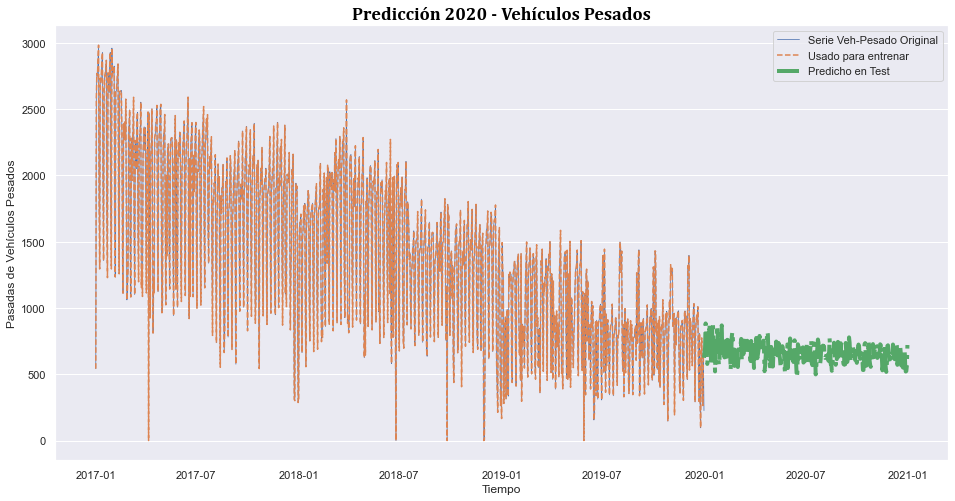

In [88]:
# Grafico comparativo entre la Serie Original, el Train y lo predicho en Train y Test.
plt.figure(figsize=(16,8))
plt.plot(psenial.index[:length_total], psenial[:length_total],lw = 0.75, label = 'Serie Veh-Pesado Original')
plt.plot(psenial.index[:N_train + look_back], psenial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(psenial.index[N_train+look_back: length_total], y_ms_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Pasadas de Vehículos Pesados')
plt.title('Predicción 2020 - Vehículos Pesados', fontdict=title_font)
plt.grid(axis='x')
plt.show();

* Se puede observar que la predicción que obtengo con mi modelo de XGBoost para Vehículos Pesados para el año 2020 no fue tan mala. Dicha predicción se obtiene con la información de un año para atrás por el cual su comportamiento resulta bastante parecido al año 2019. Teniendo mayor información (ventana hacia atrás) para predecir, en general, la predicción sería algo mejor pero para este caso en particular,  analizando la tendencia decreciente y el comportamiento de la serie considro que más información no mejoraría mucho la predicción que obtuve para el 2020.

# CONCLUSION FINAL: Modelo Veh. Liviano vs Modelo Veh. Pesados 
<img src="error_liv.png"/>

<img src="error_pes.png"/>

<img src="error_proy3.png"/>

* Como se observa en los cuadros de errores de los 3 modelos, argumento que no se justifica plantear dos modelos, uno para vehículos livianos y otro para vehículos pesados, ya que la suma de los errores obtenidos para ambos modelos es similar a la resultante en el proyecto 3. Por este motivo, concluyo que el comportamiento del modelo es el mismo, tanto para vehiculos livianos como para pesados, lo único que cambia es la cantidad de pasadas, es decir, el volumnen de tráfico de acuerdo al tipo de vehículo.

# 2.

* Incluir más features para definir mi modelo tales como tipo de Vehículo, Sentido, Día de la semana y generar así nuevamente las predicciones para el último trimeste del 2019 y todo el 2020.
- Utilizaré todos los features menos forma de pago y estación ya que para poder comparar con el Proyecto 3 solo trabajamos con la forma de pago en **Efectivo** y la estación **Illia**.  
---
---

In [89]:
# Tomo el dataset " data" que guarde para utilizarlo para mi modelo XGboost en el que incluyo más features
datax = data.copy()
datax.head(3).append(data.tail(3))

dia    sentido tipo_vehiculo  cantidad_pasos
fecha                                                                
2017-01-01 00:00:00  Domingo  Provincia        Pesado               1
2017-01-01 00:00:00  Domingo  Provincia       Liviano               9
2017-01-01 00:00:00  Domingo  Provincia       Liviano             644
2019-12-31 22:00:00   Martes     Centro       Liviano             580
2019-12-31 23:00:00   Martes     Centro       Liviano             214
2019-12-31 23:00:00   Martes  Provincia       Liviano             190

In [90]:
# Descompongo la fecha y obtengo el año, mes , día y día de la semana como nuevos features
datax['Year'] = datax.index.year
datax['Month'] = datax.index.month
datax['Day'] = datax.index.day
datax['WeekOfYear'] = datax.index.weekofyear
datax.head(3)

dia    sentido tipo_vehiculo  cantidad_pasos  Year  Month  \
fecha                                                                       
2017-01-01  Domingo  Provincia        Pesado               1  2017      1   
2017-01-01  Domingo  Provincia       Liviano               9  2017      1   
2017-01-01  Domingo  Provincia       Liviano             644  2017      1   

            Day  WeekOfYear  
fecha                        
2017-01-01    1          52  
2017-01-01    1          52  
2017-01-01    1          52

In [91]:
# Vericamos que no tenemos valores nulos
datax.isnull().sum()

dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
Year              0
Month             0
Day               0
WeekOfYear        0
dtype: int64

### a) Outliers

In [92]:
#Para ello utilizaré la función elimino_outliers que implementa los rangos interquantilicos 
dataset_outliers = elimino_outliers(datax,'cantidad_pasos')
dataset_outliers.sum()

46215

In [93]:
# Reemplazo los outliers por nan  y aplico la interpolacion a la serie
datax.cantidad_pasos[dataset_outliers] = np.nan
print(datax.isnull().sum())
datax = datax.interpolate(method='time')
print(datax.isnull().sum())

dia                   0
sentido               0
tipo_vehiculo         0
cantidad_pasos    46215
Year                  0
Month                 0
Day                   0
WeekOfYear            0
dtype: int64
dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
Year              0
Month             0
Day               0
WeekOfYear        0
dtype: int64


In [94]:
datax.cantidad_pasos.describe().round(2)

count    238869.00
mean         24.50
std          44.14
min           1.00
25%           2.00
50%           7.00
75%          26.00
max         257.00
Name: cantidad_pasos, dtype: float64

### b) Encoding

XGBoost soporta solamente números. Por lo tanto antes de modelar necesito codificar las features no numéricas y desglozar la fecha (año,mes,día)

In [95]:
# Encoding de las features no numéricos
map_sentido = {'Centro':0, 'Provincia':1}
map_vehiculo = {'Liviano':0, 'Pesado':1}
map_dia = {'Domingo':1,'Lunes':2,'Martes':3,'Miercoles':4,'Jueves':5,'Viernes':6,'Sabado':7}
datax.loc[:,'sentido'] = datax.loc[:,'sentido'].map(map_sentido)
datax.loc[:,'tipo_vehiculo'] = datax.loc[:,'tipo_vehiculo'].map(map_vehiculo)
datax.loc[:,'dia'] = datax.loc[:,'dia'].map(map_dia)

In [96]:
datax.head(3)

dia  sentido  tipo_vehiculo  cantidad_pasos  Year  Month  Day  \
fecha                                                                       
2017-01-01  1.0        1              1             1.0  2017      1    1   
2017-01-01  1.0        1              0             9.0  2017      1    1   
2017-01-01  1.0        1              0             1.0  2017      1    1   

            WeekOfYear  
fecha                   
2017-01-01          52  
2017-01-01          52  
2017-01-01          52

In [97]:
datax.drop(columns=['dia'], inplace=True)

## Defino mi modelo

In [98]:
# Defino mi set de train y de test
# Excluyo a mi variable objetivo --> cantidad_pasos
X = datax[['sentido', 'tipo_vehiculo', 'Year', 'Month', 'Day', 'WeekOfYear']]
y = datax[['cantidad_pasos']]

# Divido los datos en train y test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [99]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(167208, 6) (167208, 1)
(71661, 6) (71661, 1)


In [100]:
# Parámetros iniciales
params = {
    'objective': 'reg:squarederror', 
    'subsample': 0.8, 
    'colsample_bytree': 0.85, 
    'learning_rate': 0.3, 
    'max_depth': 10, 
    'seed': 42} 
steps = 50

In [101]:
modelxg = XGBRegressor(**params)
modelxg.fit(X_train, y_train,eval_set=[(X_train, y_train),(X_test, y_test)],early_stopping_rounds = steps)

[0]	validation_0-rmse:45.04450	validation_1-rmse:45.38281
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:42.08363	validation_1-rmse:42.45571
[2]	validation_0-rmse:40.52373	validation_1-rmse:40.93192
[3]	validation_0-rmse:39.99757	validation_1-rmse:40.44450
[4]	validation_0-rmse:39.38654	validation_1-rmse:39.85473
[5]	validation_0-rmse:39.04281	validation_1-rmse:39.53346
[6]	validation_0-rmse:38.81681	validation_1-rmse:39.34196
[7]	validation_0-rmse:38.66931	validation_1-rmse:39.21455
[8]	validation_0-rmse:38.61443	validation_1-rmse:39.17927
[9]	validation_0-rmse:38.54956	validation_1-rmse:39.14027
[10]	validation_0-rmse:38.52147	validation_1-rmse:39.12524
[11]	validation_0-rmse:38.45654	validation_1-rmse:39.08120
[12]	validation_0-rmse:38.37433	validation_1-rmse:39.01925
[13]	validation_0-rmse:38.31432	validation_1-rmse:38.99358
[14]	validation_0-rmse:38

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.85, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

### Optimizo los hiperparámetros

In [102]:
params_sk = {
    'max_depth': range (2, 20, 2),
    'min_child_weight': [4],
    'n_estimators': range(60, 220, 300),
    'colsample_bytree': [0.1,0.3,0.5,0.7,1],
    'learning_rate': [0.1, 0.01, 0.05]
}

modelxg_opt= RandomizedSearchCV(modelxg, params_sk,  n_jobs=10, cv=10,
                                 verbose=True, scoring='neg_mean_squared_error')

modelxg_opt.fit(X_train, y_train)

#Imprimo los mejores Hiperpaámetros
print('Mejores Hiperparámetros: '+str(modelxg_opt.best_params_))
print('Mejor Score:'+str(modelxg_opt.best_score_)+'\n')

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  5.5min finished


Mejores Hiperparámetros: {'n_estimators': 60, 'min_child_weight': 4, 'max_depth': 14, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Mejor Score:-1506.4490652212494



In [103]:
# Defino el modelo con los mejores Hiperpáremtros obtenidos 
params_op = {'max_depth': 14, 
            'n_estimators': 60, 
            'min_child_weight':4,
            'objective': 'reg:squarederror', 
            'colsample_bytree': 0.7, 
            'learning_rate': 0.1 ,
            'seed': 42}   

modelxg_final = xgb.XGBRegressor(**params_op)


# Entreno  el modelo 
modelxg_final.fit(X_train, y_train,eval_set=[(X_train, y_train),(X_test, y_test)],early_stopping_rounds = steps)

[0]	validation_0-rmse:48.26615	validation_1-rmse:48.60972
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:46.68143	validation_1-rmse:47.04384
[2]	validation_0-rmse:45.38476	validation_1-rmse:45.74518
[3]	validation_0-rmse:44.66872	validation_1-rmse:45.05197
[4]	validation_0-rmse:44.07314	validation_1-rmse:44.47817
[5]	validation_0-rmse:43.58247	validation_1-rmse:43.99814
[6]	validation_0-rmse:43.17825	validation_1-rmse:43.61514
[7]	validation_0-rmse:42.34893	validation_1-rmse:42.80763
[8]	validation_0-rmse:42.05521	validation_1-rmse:42.53984
[9]	validation_0-rmse:41.50190	validation_1-rmse:41.98302
[10]	validation_0-rmse:41.31294	validation_1-rmse:41.80162
[11]	validation_0-rmse:41.15700	validation_1-rmse:41.65398
[12]	validation_0-rmse:40.72695	validation_1-rmse:41.22324
[13]	validation_0-rmse:40.61631	validation_1-rmse:41.12703
[14]	validation_0-rmse:40

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=14,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=60, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [104]:
# Predigo 
y_pred = modelxg_final.predict(X)
y_train_pred = modelxg_final.predict(X_train)
y_test_pred = modelxg_final.predict(X_test)

In [105]:
# Calculo el RMSE  y el MAPE en train y test
MSE = mean_squared_error(y_train, y_train_pred)
print('RMSE en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('RMSE en Test:',np.sqrt(MSE))

RMSE en Train: 38.18966265972015
RMSE en Test: 38.99098086242414


# CONCLUSION FINAL: Modelo XGBoost con todos los features

Según el error en train y test, se observa que el modelo para ambos dataset funciona de manera similar con un `error promedio de 39 pasadas por hora`. Dado que el modelo XGBoost implementado en el proyecto 3 trabaja con un resampleo diario con el fin de poder compararlo, debo llevar mi nueva predicción con todos los features a día, siendo el resultado de dicha conversión igual a 912 cantidad de pasadas. 

De esta forma, teniendo ahora los dos modelos en la misma unidad, y observando ambos errores (`modelo XGBoost proyecto 3 igual a 4713` y `modelo XGBoost del proyecto 4 igual a 912`), determino que el error obtenido con el modelo XGBoost del proyecto 4 es sustancialmente menor del proyecto 3, por lo que concluyo que, con la incorporación de más features, el modelo logra una mejor predicción.

# 3.

* Optimizar el modelo obtenido con Prophet para predecir el año 2020 y en este caso implementaré la búsqueda de los mejores hiperparametros.

In [106]:
# Tomo el dataset " data" que guarde para utilizarlo para mi predicción mejorada de Prophet
data.head(3).append(data.tail(3))

dia    sentido tipo_vehiculo  cantidad_pasos
fecha                                                                
2017-01-01 00:00:00  Domingo  Provincia        Pesado               1
2017-01-01 00:00:00  Domingo  Provincia       Liviano               9
2017-01-01 00:00:00  Domingo  Provincia       Liviano             644
2019-12-31 22:00:00   Martes     Centro       Liviano             580
2019-12-31 23:00:00   Martes     Centro       Liviano             214
2019-12-31 23:00:00   Martes  Provincia       Liviano             190

In [107]:
# Resampleo mi dataset por Día
diario = data.resample('D').sum()
print(diario.shape)
diario.head()

(1095, 1)


cantidad_pasos
fecha                     
2017-01-01           31183
2017-01-02           51568
2017-01-03           51093
2017-01-04           53332
2017-01-05           56486

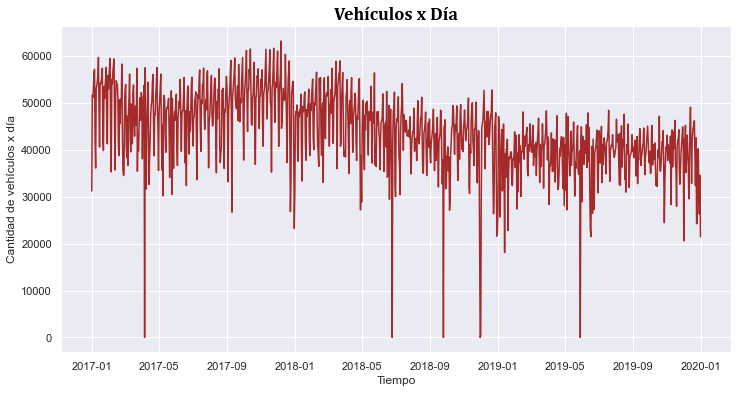

In [108]:
# Visulizo la serie diario
plt.figure(figsize = (12,6))
plt.plot(diario.index, diario.cantidad_pasos,color='brown')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos x día')
plt.title('Vehículos x Día', fontdict=title_font)
plt.show();

In [109]:
# Analizamos los outliers
data_outliers = elimino_outliers(diario,'cantidad_pasos')
data_outliers.sum()

16

In [110]:
# Reemplazo los outliers por nan  y aplico la interpolacion a la serie
diario[data_outliers] = np.nan
print(diario.isnull().sum())
diario = diario.interpolate(method='time')
print(diario.isnull().sum())

cantidad_pasos    16
dtype: int64
cantidad_pasos    0
dtype: int64


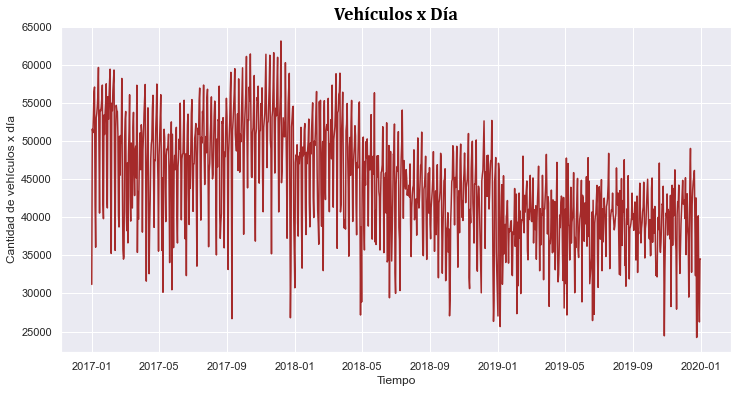

In [111]:
# Grafico nuevamente la serie sin los outliers
plt.figure(figsize = (12,6))
plt.plot(diario.index, diario.cantidad_pasos,color='brown')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos x día')
plt.title('Vehículos x Día', fontdict=title_font)
plt.show();

In [112]:
diario.head(3).append(diario.tail(3))

cantidad_pasos
fecha                     
2017-01-01         31183.0
2017-01-02         51568.0
2017-01-03         51093.0
2019-12-29         26259.0
2019-12-30         34523.0
2019-12-31         34523.0

In [113]:
# Transformo el dataset al formato requerido por Prophet
df20 = diario.reset_index()
df20.columns = ['ds', 'y']
df20.head(3).append(df20.tail(3))

ds        y
0    2017-01-01  31183.0
1    2017-01-02  51568.0
2    2017-01-03  51093.0
1092 2019-12-29  26259.0
1093 2019-12-30  34523.0
1094 2019-12-31  34523.0

### Defino y entreno mi Modelo Prophet

In [114]:
m = Prophet(daily_seasonality=True)
m.fit(df20)

In [115]:
# Realizo mi predicción, como voy a predecir el año 2020 utilizo 366 dias como periodo 
future20 = m.make_future_dataframe(periods=366, freq='D')
forecast = m.predict(future20)

In [116]:
forecast.tail().T

1456                 1457  \
ds                          2020-12-27 00:00:00  2020-12-28 00:00:00   
trend                                   20298.1              20289.9   
yhat_lower                              19952.8              24958.1   
yhat_upper                              31825.6              37181.3   
trend_lower                             18385.2              18367.7   
trend_upper                               22052              22050.8   
additive_terms                          5640.82              11057.6   
additive_terms_lower                    5640.82              11057.6   
additive_terms_upper                    5640.82              11057.6   
daily                                   14181.2              14181.2   
daily_lower                             14181.2              14181.2   
daily_upper                             14181.2              14181.2   
weekly                                 -6715.47             -1073.08   
weekly_lower                           -6715.47             -1073.08   
weekly_upper                           -6715.47             -1073.08   
yearly                                 -1824.96             -2050.54   
yearly_lower                           -1824.96             -2050.54   
yearly_upper                           -1824.96             -2050.54   
multiplicative_terms                          0                    0   
multiplicative_terms_lower                    0                    0   
multiplicative_terms_upper                    0                    0   
yhat                                    25938.9              31347.5   

                                           1458                 1459  \
ds                          2020-12-29 00:00:00  2020-12-30 00:00:00   
trend                                   20281.6              20273.3   
yhat_lower                              26168.3              27707.9   
yhat_upper                              38258.5              39438.1   
trend_lower                             18356.3              18344.9   
trend_upper                             22049.7              22048.5   
additive_terms                          11963.4              13614.7   
additive_terms_lower                    11963.4              13614.7   
additive_terms_upper                    11963.4              13614.7   
daily                                   14181.2              14181.2   
daily_lower                             14181.2              14181.2   
daily_upper                             14181.2              14181.2   
weekly                                  26.3009              1837.36   
weekly_lower                            26.3009              1837.36   
weekly_upper                            26.3009              1837.36   
yearly                                 -2244.12             -2403.92   
yearly_lower                           -2244.12             -2403.92   
yearly_upper                           -2244.12             -2403.92   
multiplicative_terms                          0                    0   
multiplicative_terms_lower                    0                    0   
multiplicative_terms_upper                    0                    0   
yhat                                      32245                33888   

                                           1460  
ds                          2020-12-31 00:00:00  
trend                                   20265.1  
yhat_lower                                29233  
yhat_upper                              41190.9  
trend_lower                             18330.2  
trend_upper                             22047.3  
additive_terms                          14861.2  
additive_terms_lower                    14861.2  
additive_terms_upper                    14861.2  
daily                                   14181.2  
daily_lower                             14181.2  
daily_upper                             14181.2  
weekly                                  3208.73  
weekly_lower                 

In [117]:
forecast20 = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [118]:
# Listo los valores obtenidos para el 2020
forecast20.tail(10)

ds          yhat    yhat_lower    yhat_upper
1451 2020-12-22  34228.233436  28070.736972  40125.764164
1452 2020-12-23  35691.478953  29417.057055  41425.914382
1453 2020-12-24  36730.104304  30499.774274  42797.404210
1454 2020-12-25  38387.896543  32027.573334  44150.428536
1455 2020-12-26  30454.094836  23979.497416  36436.211204
1456 2020-12-27  25938.922580  19952.815436  31825.597062
1457 2020-12-28  31347.480606  24958.107993  37181.270648
1458 2020-12-29  32245.024981  26168.312210  38258.501317
1459 2020-12-30  33888.028776  27707.932654  39438.063239
1460 2020-12-31  35126.279248  29233.030244  41190.878761

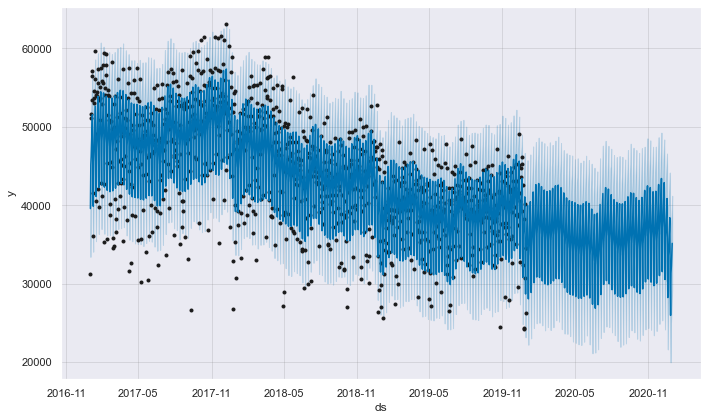

In [119]:
# Realizamos el gráfico de mi Forecast
m.plot(forecast);

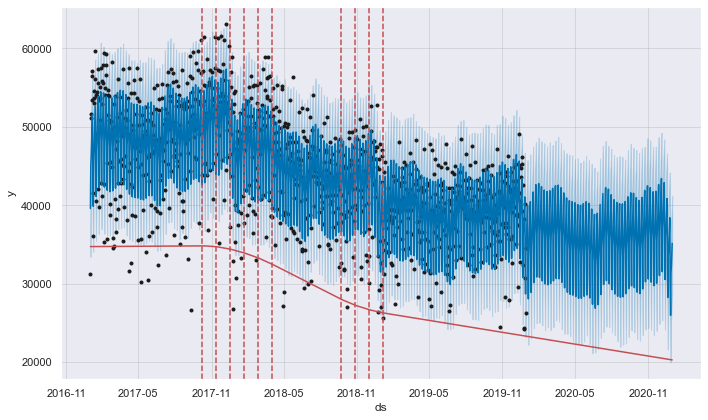

In [120]:
# Utilizo la funcionalidad de prophet para visualizar los puntos de cambios de mi dataset
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

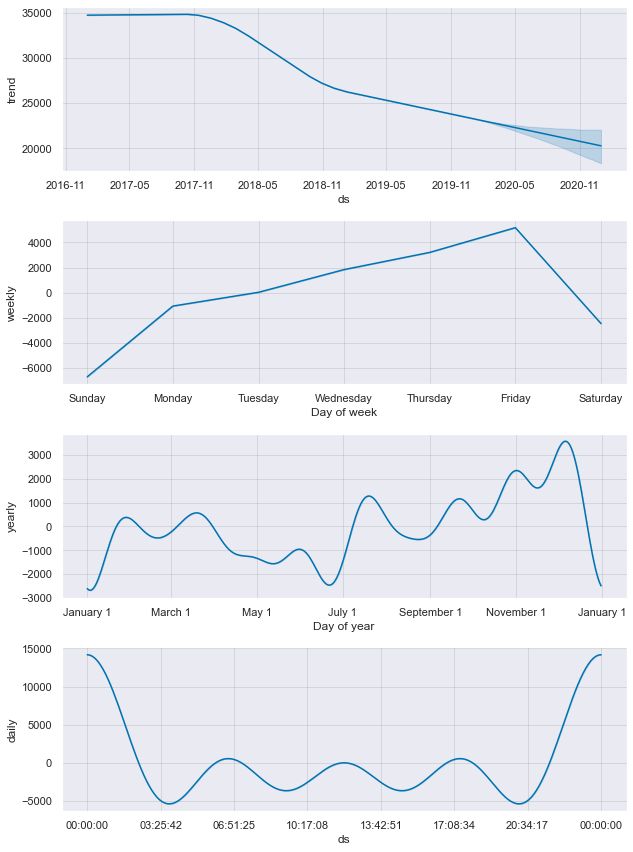

In [121]:
# Grafico los componentes de mi forecast
m.plot_components(forecast);

* Utilizo la funcionalidad que incluye Prophet de la validación cruzada de series de tiempo para medir el error del forecast.

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-07-28 00:00:00 and 2018-12-30 00:00:00


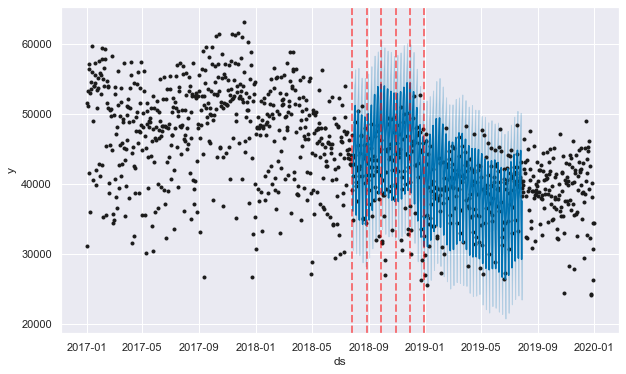

In [122]:
#Initial: dejamos 1 año medio para entrenamiento
#Horizon: usamos 366 días para validación.
#Prevision: 31 días

df_cv = cross_validation(m, initial='548 days', period ='31 days', horizon = '366 days')
cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
cutoff = df_cv['cutoff'].unique()[0]
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(m.history['ds'].values, m.history['y'], 'k.')
ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)

#ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')

# Hacemos todas las vlines de cutoffs
for item in cutoffs:
  ax.axvline(x=pd.to_datetime(item), c='red', lw=2, alpha=0.5, ls='--')

* Mediante el uso del método de Prophet denominado `performance_metrics`, evaluamos las métricas del error obtenido con el cross validation.

In [123]:
df_p = performance_metrics(df_cv)
df_p.head(5)

horizon           mse         rmse          mae      mape     mdape  \
0 36 days  1.105126e+07  3324.343691  2403.311355  0.058551  0.040883   
1 37 days  1.112992e+07  3336.153612  2426.064798  0.058938  0.043602   
2 38 days  1.099105e+07  3315.275369  2401.319861  0.058293  0.043602   
3 39 days  1.117289e+07  3342.587196  2429.837612  0.058919  0.043602   
4 40 days  1.116568e+07  3341.508534  2428.923999  0.058825  0.043602   

   coverage  
0  0.888889  
1  0.888889  
2  0.888889  
3  0.888889  
4  0.888889

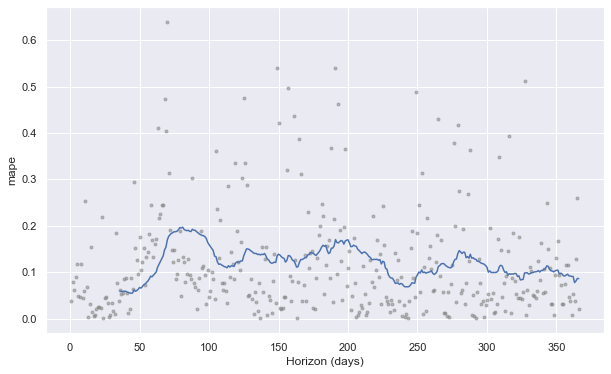

In [124]:
# Grafico el error MAPE
fig = plot_cross_validation_metric(df_cv, metric='mape')

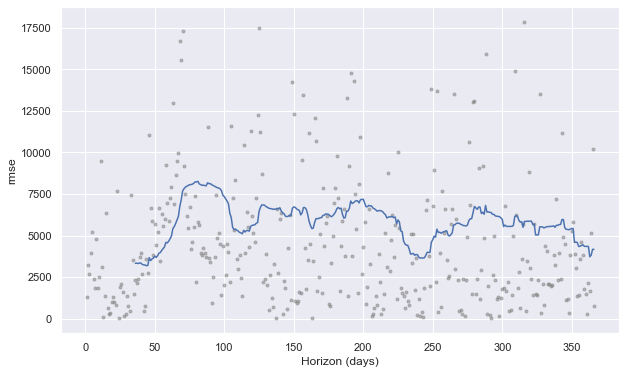

In [125]:
# Grafico el error RMSE
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [126]:
df_p.mean()

horizon     201 days 00:00:00
mse               3.53265e+07
rmse                  5825.99
mae                    4558.5
mape                  0.12082
mdape               0.0851268
coverage             0.670023
dtype: object

* En los gráficos de error se puede observar que la `línea azul`, la cual `representa la métrica MAPE y RMSE`, se encuentra en un promedio de alrededor `12% para MAPE  y 5825 para RSME`.

In [127]:
# Dibujamos y verificamos el modelo completo, es decir con todo sus componentes
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df20['ds'], y=df20['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Prediction',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yearly'], name='Yearly',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['weekly'], name='Weekly',))
fig.show();

* Compruebo que el pronóstico del modelo es en realidad la suma de sus componentes para ello ejecuto las siguientes sentencias:

In [128]:
# Imprimo la suma de yhat (la predicción)
sum_yhat = forecast['yhat'].sum()
print('Suma de mi Forecast :', sum_yhat)

sum_components = forecast['trend'].sum()+forecast['yearly'].sum()+ forecast['weekly'].sum() +forecast['daily'].sum()
print('Suma de los componentes:', sum_components)
# Valido mi hipótesis
print('El modelo es igual a la suma de los componentes:', sum_yhat.round()==sum_components.round())

Suma de mi Forecast : 61414689.23432467
Suma de los componentes: 61414689.23432467
El modelo es igual a la suma de los componentes: True


### Optimizo los hiperparámetros

*  Con el fin de poder realizar una comparación entre errores  (RMSE y MAPE) sin tener que cambiar los datos, defino funciones que utilizo para guardar las diferentes métricas que obtengo a través de la validación cruzada.

In [129]:
# Creo estas funciones para probar diferentes configuraciones de cross validation
def getPerfomanceMetrics(m):
  return performance_metrics(getCrossValidationData(m))

def getCrossValidationData(m):
 return cross_validation(m, initial='548 days', period ='31 days', horizon = '366 days')

In [130]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict, parallel):
    m = Prophet(**param_dict,daily_seasonality=True)
    m.fit(history_df)
    df_cv = getCrossValidationData(m)
    df_p = performance_metrics(df_cv, rolling_window=1)
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p


pd.set_option('display.max_colwidth', None)
param_grid = {                  
                'changepoint_prior_scale': [0.05, 0.1],
                'changepoint_range': [0.3, 0.75],
                'seasonality_prior_scale':[1.0, 2.5],
                'yearly_seasonality':[20],
                'weekly_seasonality':[10]
              }
metrics = ['horizon', 'rmse', 'mae', 'mape', 'mdape','params'] 
results = []

#Prophet()
params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(df20,  metrics, param_dict, parallel='processes')
    results.append(cv_df)
results_df = pd.concat(results).reset_index(drop=True)
best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df.mean()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-07-28 00:00:00 and 2018-12-30 00:00:00


INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-07-28 00:00:00 and 2018-12-30 00:00:00


INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-07-28 00:00:00 and 2018-12-30 00:00:00


INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-07-28 00:00:00 and 2018-12-30 00:00:00


INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-07-28 00:00:00 and 2018-12-30 00:00:00


INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-07-28 00:00:00 and 2018-12-30 00:00:00


INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-07-28 00:00:00 and 2018-12-30 00:00:00


INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-07-28 00:00:00 and 2018-12-30 00:00:00




 The best param combination is {'changepoint_prior_scale': 0.1, 'changepoint_range': 0.3, 'seasonality_prior_scale': 1.0, 'yearly_seasonality': 20.0, 'weekly_seasonality': 10.0}


horizon    366 days 00:00:00
rmse                 7996.37
mae                   6452.5
mape                0.166927
mdape               0.143663
dtype: object

In [131]:
# Defino el modelo Prophet con los mejores Hiperpáremtros obtenidos 
m = Prophet( changepoint_prior_scale=0.1,
            changepoint_range=0.3,
            seasonality_prior_scale=1,
            yearly_seasonality=20,
            weekly_seasonality=10,
            daily_seasonality=True
            )

# Entreno nuevamente el modelo con los mejores hiperparámetros
m.fit(df20)
getPerfomanceMetrics(m).mean()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-07-28 00:00:00 and 2018-12-30 00:00:00


horizon     201 days 12:00:00
mse               3.85291e+07
rmse                  6191.53
mae                   4797.79
mape                 0.126905
mdape               0.0941908
coverage             0.708939
dtype: object

In [132]:
# Realizo nuevamente mi predicción pero con el modelo entrenado con los mejores hiperpaámetros 
future20_opt = m.make_future_dataframe(periods=366, freq='D')
forecast_opt = m.predict(future20_opt)

In [133]:
forecast_opt[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail().T

1456                 1457                 1458  \
ds          2020-12-27 00:00:00  2020-12-28 00:00:00  2020-12-29 00:00:00   
yhat                    19695.5              24938.3              25772.7   
yhat_lower              13357.1              18950.9              18992.5   
yhat_upper              25984.3              31059.2              31716.1   

                           1459                 1460  
ds          2020-12-30 00:00:00  2020-12-31 00:00:00  
yhat                      27434              28808.5  
yhat_lower              21141.7              22868.1  
yhat_upper              33973.2                34833

In [134]:
# Dibujamos y verificamos el modelo mejorado  completo, es decir con todo sus componentes
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df20['ds'], y=df20['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast_opt['ds'], y=forecast_opt['yhat'], name='Prediction',))
fig.add_trace(go.Scatter(x=forecast_opt['ds'], y=forecast_opt['trend'], name='Trend',))
fig.add_trace(go.Scatter(x=forecast_opt['ds'], y=forecast_opt['yearly'], name='Yearly',))
fig.add_trace(go.Scatter(x=forecast_opt['ds'], y=forecast_opt['weekly'], name='Weekly',))
fig.show();

* Compruebo nuevamente que el pronóstico del modelo mejorado es en realidad la suma de sus componentes para ello ejecuto las siguientes sentencias:

In [135]:
# Imprimo la suma de yhat (la predicción)
sum_yhat = forecast_opt['yhat'].sum()
print('Suma de mi Forecast_opt :', sum_yhat)

sum_components = forecast_opt['trend'].sum()+forecast_opt['yearly'].sum()+ forecast_opt['weekly'].sum() +forecast_opt['daily'].sum()
print('Suma de los componentes:', sum_components)
# Valido mi hipótesis
print('El modelo es igual a la suma de los componentes:', sum_yhat.round()==sum_components.round())

Suma de mi Forecast_opt : 60256064.43287437
Suma de los componentes: 60256064.43287437
El modelo es igual a la suma de los componentes: True


In [136]:
forecast20_opt = forecast_opt[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast20_opt.columns = ['ds_opt','yhat_opt', 'yhatlow_opt', 'yhatupp_opt']

In [137]:
comparacion = forecast20.set_index('ds').join(forecast20_opt.set_index('ds_opt'))
comparacion.tail(10)

yhat    yhat_lower    yhat_upper      yhat_opt  \
ds                                                                   
2020-12-22  34228.233436  28070.736972  40125.764164  29934.838343   
2020-12-23  35691.478953  29417.057055  41425.914382  30909.798686   
2020-12-24  36730.104304  30499.774274  42797.404210  31498.052298   
2020-12-25  38387.896543  32027.573334  44150.428536  32747.263630   
2020-12-26  30454.094836  23979.497416  36436.211204  24469.692383   
2020-12-27  25938.922580  19952.815436  31825.597062  19695.492318   
2020-12-28  31347.480606  24958.107993  37181.270648  24938.318581   
2020-12-29  32245.024981  26168.312210  38258.501317  25772.725729   
2020-12-30  33888.028776  27707.932654  39438.063239  27433.959133   
2020-12-31  35126.279248  29233.030244  41190.878761  28808.498222   

             yhatlow_opt   yhatupp_opt  
ds                                      
2020-12-22  24028.348332  35817.400903  
2020-12-23  24136.384995  36691.600448  
2020-12-24  25567.875317  37641.898456  
2020-12-25  27192.703527  38751.247916  
2020-12-26  18494.191703  30087.941941  
2020-12-27  13357.115664  25984.253052  
2020-12-28  18950.861512  31059.246119  
2020-12-29  18992.469344  31716.081948  
2020-12-30  21141.680283  33973.249636  
2020-12-31  22868.138667  34833.018736

In [138]:
def forecast_errors(comparacion):
    
    comp_resultados = comparacion
    comp_resultados['error'] = comp_resultados['yhat'] - comp_resultados['yhat_opt']
    RMSE = np.sqrt(mean_squared_error(comp_resultados['yhat'], comp_resultados['yhat_opt']))
    return comp_resultados[['yhat','yhat_opt', 'error']], RMSE,MAPE(comp_resultados['yhat'], comp_resultados['yhat_opt'])

In [139]:
forecast_errors(comparacion)

(                    yhat      yhat_opt        error
 ds                                                 
 2017-01-01  39558.842273  39333.745148   225.097125
 2017-01-02  45147.629893  45195.057045   -47.427152
 2017-01-03  46228.145646  46591.460899  -363.315253
 2017-01-04  48053.837233  48732.062174  -678.224941
 2017-01-05  49471.553497  50483.600271 -1012.046774
 ...                  ...           ...          ...
 2020-12-27  25938.922580  19695.492318  6243.430262
 2020-12-28  31347.480606  24938.318581  6409.162025
 2020-12-29  32245.024981  25772.725729  6472.299252
 2020-12-30  33888.028776  27433.959133  6454.069642
 2020-12-31  35126.279248  28808.498222  6317.781026
 
 [1461 rows x 3 columns],
 1927.8381128444971,
 3.764530949952252)

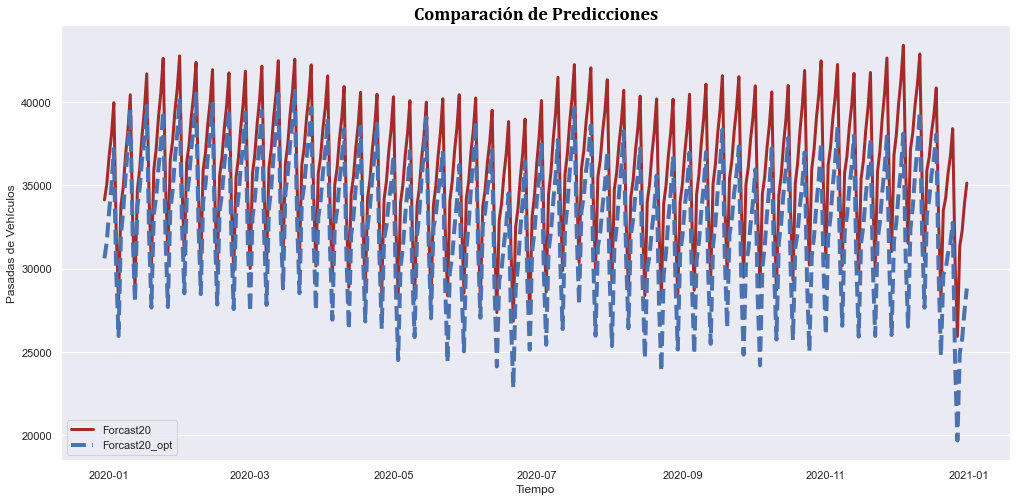

In [140]:
plt.figure(figsize=(17, 8))
plt.plot(comparacion['yhat'][1093:1461],lw = 3, label = 'Forcast20', color='brown')
plt.plot(comparacion['yhat_opt'][1093:1461],'--', lw = 4, label = 'Forcast20_opt')
#plt.plot(comparacion['yhat_opt'][1093:1461],'-.', lw = 4, label = 'Forcast20'))
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Pasadas de Vehículos')
plt.title('Comparación de Predicciones', fontdict=title_font)
plt.grid(axis='x')
plt.show();


# CONCLUSION FINAL: Modelo Prophet optimizado

A partir del resultado de la comparación de Prophet entre la predicción con los valores por defecto `(forecast20)`, versus el forcast con los mejores hiperparámetros optimizados `(forecast20_opt)`, se ha puesto en evidencia que esta última es notablemente superior. La predicción Prophet, obtenida con los mejores hiperparámetros, arroja un error `RMSE igual a 1927`pasadas, y un error`MAPE igual a 3.7%`; mientras que los errores hallados en la predicción con los valores por defecto, resultaron ser `RMSE 5825` pasadas y `MAPE 12%`. 

---
---
Como conclusión final, considero que, de todos los modelos implementados en este proyecto final, el de Prophet, entrenado con los mejores hiperparámetros, no sólo es el que obtiene los menores errores en la predicción, sino que además es el más simple de implementar, además de ser el modelo específico para las series de tiempo. 